In [536]:
# => makes the plot interactive
%matplotlib notebook 
# inline makes the plots static
#%matplotlib inline 

import numpy as np
#import astropy as astropy
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import warnings
# filter astropy warning on fits headers
warnings.filterwarnings('ignore', category=UserWarning, append=True)



def plot_spectrum_panels(xaxis,data,num_panels=2):
    spectrum_data=np.copy(data)

    # Divide the spectrum into four panels
    panel_height = len(spectrum_data) // num_panels

    # Create subplots
    fig, axs = plt.subplots(num_panels, 1, figsize=(15, 6*num_panels))

    # Plot each panel
    for i in range(num_panels):
        start_idx = i * panel_height
        end_idx = (i + 1) * panel_height
        xaxis= list(range(len(spectrum_data)))
        axs[i].plot(xaxis[start_idx:end_idx],spectrum_data[start_idx:end_idx])
#        axs[i].set_xlabel('Wavelength (Angstroms)')
        axs[i].set_ylabel('counts(ADU)')
        axs[i].set_title(f'Panel {i + 1}')
        axs[i].grid(True)

#    plt.tight_layout()
#    plt.show()

def read_raw_spectrum(fits_file):
    # returns an index and the fluxes
    # Open the FITS file
    hdulist = fits.open(fits_file)
    # Assuming the spectrum data is in the first extension (HDU index 0)
    data = hdulist[0].data[0]
    xaxis= list(range(len(data)))
    return xaxis,data

def read_calibrated_spectrum(fits_file):
    # Open the FITS file
    with fits.open(fits_file) as hdul:
        # Extract the data and header from the primary HDU
        data = hdul[0].data[0]
        header = hdul[0].header

        # Extract necessary header keywords for calibration
        crval1 = header['CRVAL1']  # Reference value of the first pixel (wavelength)
        cdelt1 = header['CDELT1']  # Pixel scale (wavelength per pixel)
        naxis1 = header['NAXIS1']  # Number of pixels in the spectral axis

        # Create an array of calibrated wavelengths
        wavelengths = crval1 + np.arange(naxis1) * cdelt1
    return wavelengths,data


# Define the Gaussian function
def gaussian(x, *params):
    result= np.full(len(x),0.)
    for i in range(0, len(params), 3):
        amp, cen, wid = params[i:i+3]
        result += amp * np.exp(-(x - cen) ** 2 / (2 * wid ** 2))
    return result

def generate_first_guess(peaks):
#    npeaks=len(peaks[:3])
    npeaks=len(peaks)
    initial_cen=peaks
    initial_amp=np.full(npeaks,20000.)
    initial_wid=np.full(npeaks,1.)
#    print(initial_cen)
#    print(initial_amp)
#    print(initial_wid)
    first_guess=np.full((npeaks,3),0.)
    for i in range(npeaks):
        first_guess[i,0]=initial_amp[i]
        first_guess[i,1]=initial_cen[i]
        first_guess[i,2]=initial_wid[i]
    first_guess=np.reshape(first_guess,3*npeaks)
#    print(first_guess)
    return first_guess





2142


<IPython.core.display.Javascript object>


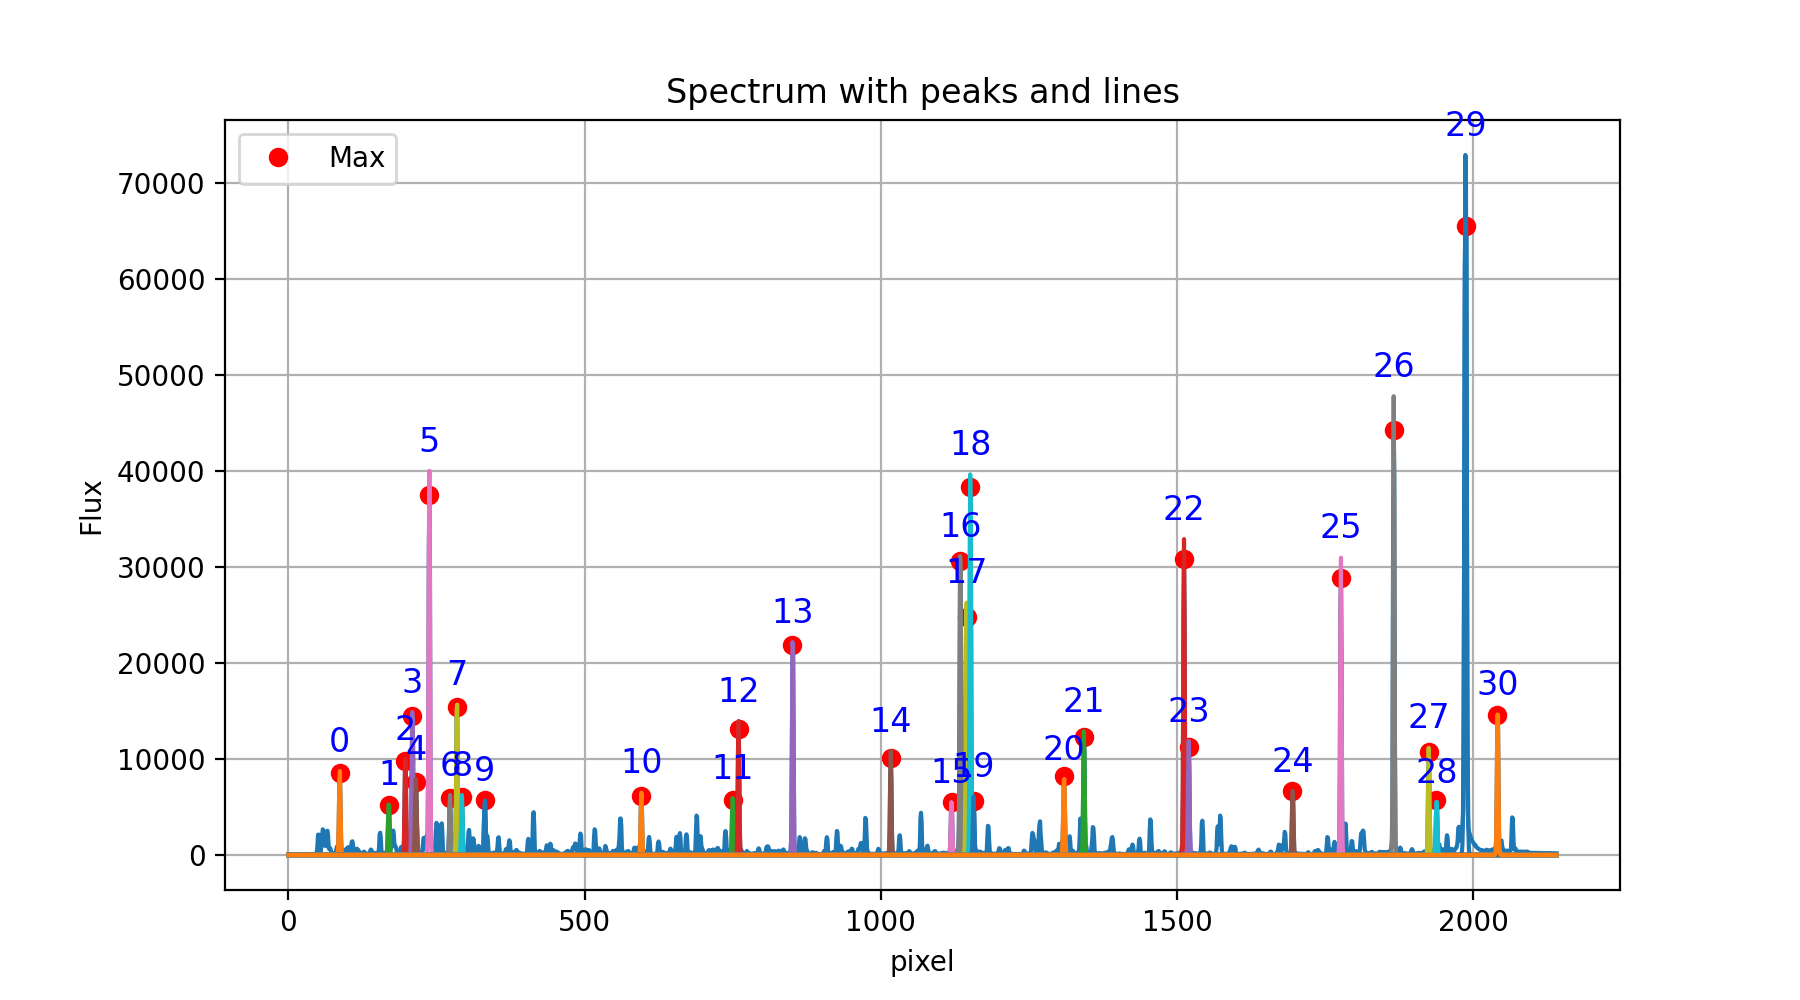

In [540]:
fits_file = '../data/t152_spectro/lamp_thar/p67507.fits'
xaxis,data=read_raw_spectrum(fits_file)
spectrum=data
print(len(xaxis))
# Find peaks in the spectrum
peaks, _ = find_peaks(data, height=5000.)  # You can adjust the 'height' threshold

# Get the centroid (x-value) of each peak
centroid_x_values = peaks

# Plot the spectrum and mark the centroids
plt.figure(figsize=(9, 5))
plt.plot(data)
plt.plot(centroid_x_values, data[peaks], 'ro', label='Max')
plt.xlabel('pixel')
plt.ylabel('Flux')
plt.title('Spectrum with peaks and lines')
plt.grid(True)

# generate first_guess
first_guess=generate_first_guess(peaks)
#print(first_guess)
# fit gaussian lines:
params, covariance = curve_fit(gaussian, xaxis, data, p0=first_guess)
#print(np.shape(covariance))
# Reshape params into a 2D array (N, 3) for readability
num_peaks = len(params) // 3
#print('num_peaks',num_peaks)
params = np.array(params).reshape((num_peaks, 3))
allamps=params[:,0]
allcens=params[:,1]
allwids=params[:,2]

if(0):
    # remove the huge saturaed line at pixel 1987  & 6965 Angstrom
    print(len(allcens))
    ibad=np.argmin(np.abs(allcens-1987.))
    print(ibad)
    allcens=np.delete(allcens,ibad)
    print(len(allcens))
    allamps=np.delete(allamps,ibad)
    allwids=np.delete(allwids,ibad)
    print(allcens)

# plot individual lines for check
for i in range(num_peaks):
    fit_params = params[i]  # Extract parameters for each Gaussian
    gau=gaussian(xaxis, *fit_params)
    plt.plot(xaxis, gau)#, label=f'Gaussian {i+1}')
    plt.text(allcens[i], np.max(gau)+3000, str(i), fontsize=12, ha='center', va='center', color='blue')

plt.legend()
plt.show()

if(0):
    plt.figure(figsize=(6,6))
    plt.imshow(covariance)
    plt.colorbar()
    plt.show()

<IPython.core.display.Javascript object>


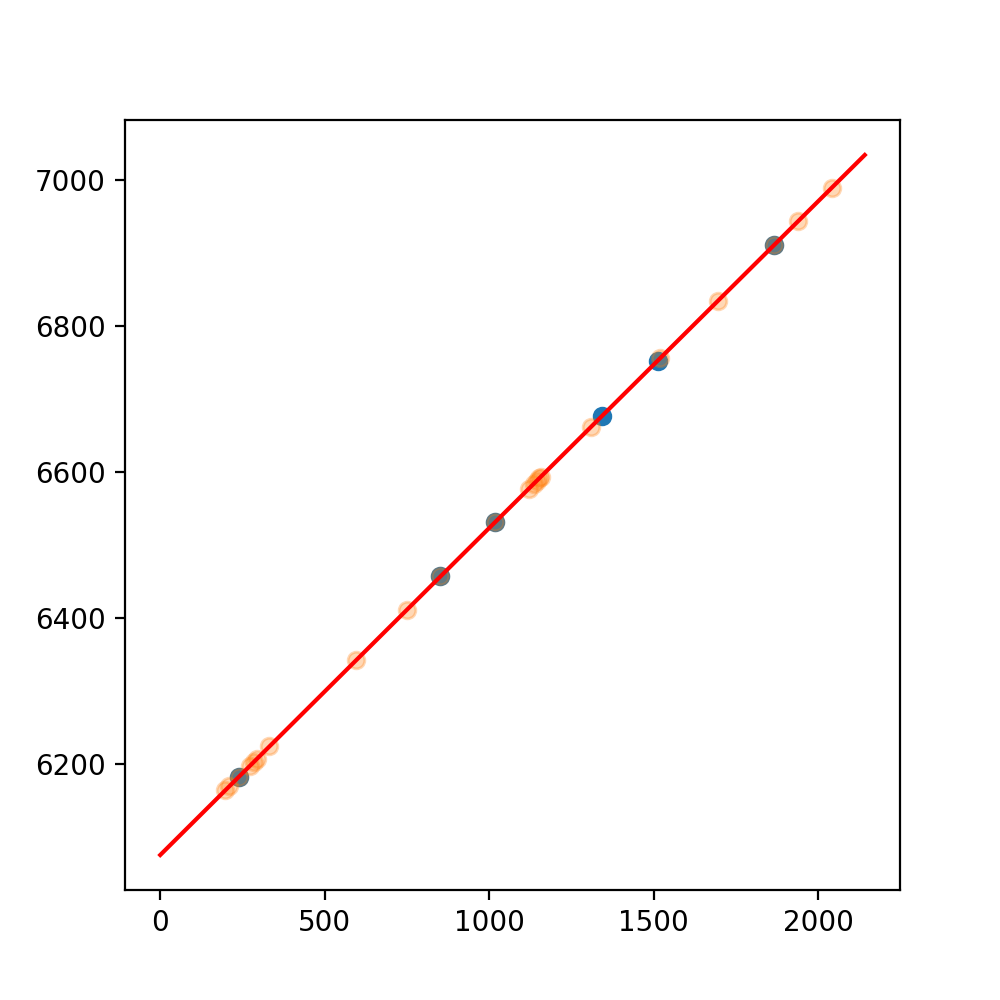

ThI.csv 1376
[ 6.07605504e+03  4.47964369e-01 -1.58478693e-07  1.25427547e-11]


<IPython.core.display.Javascript object>


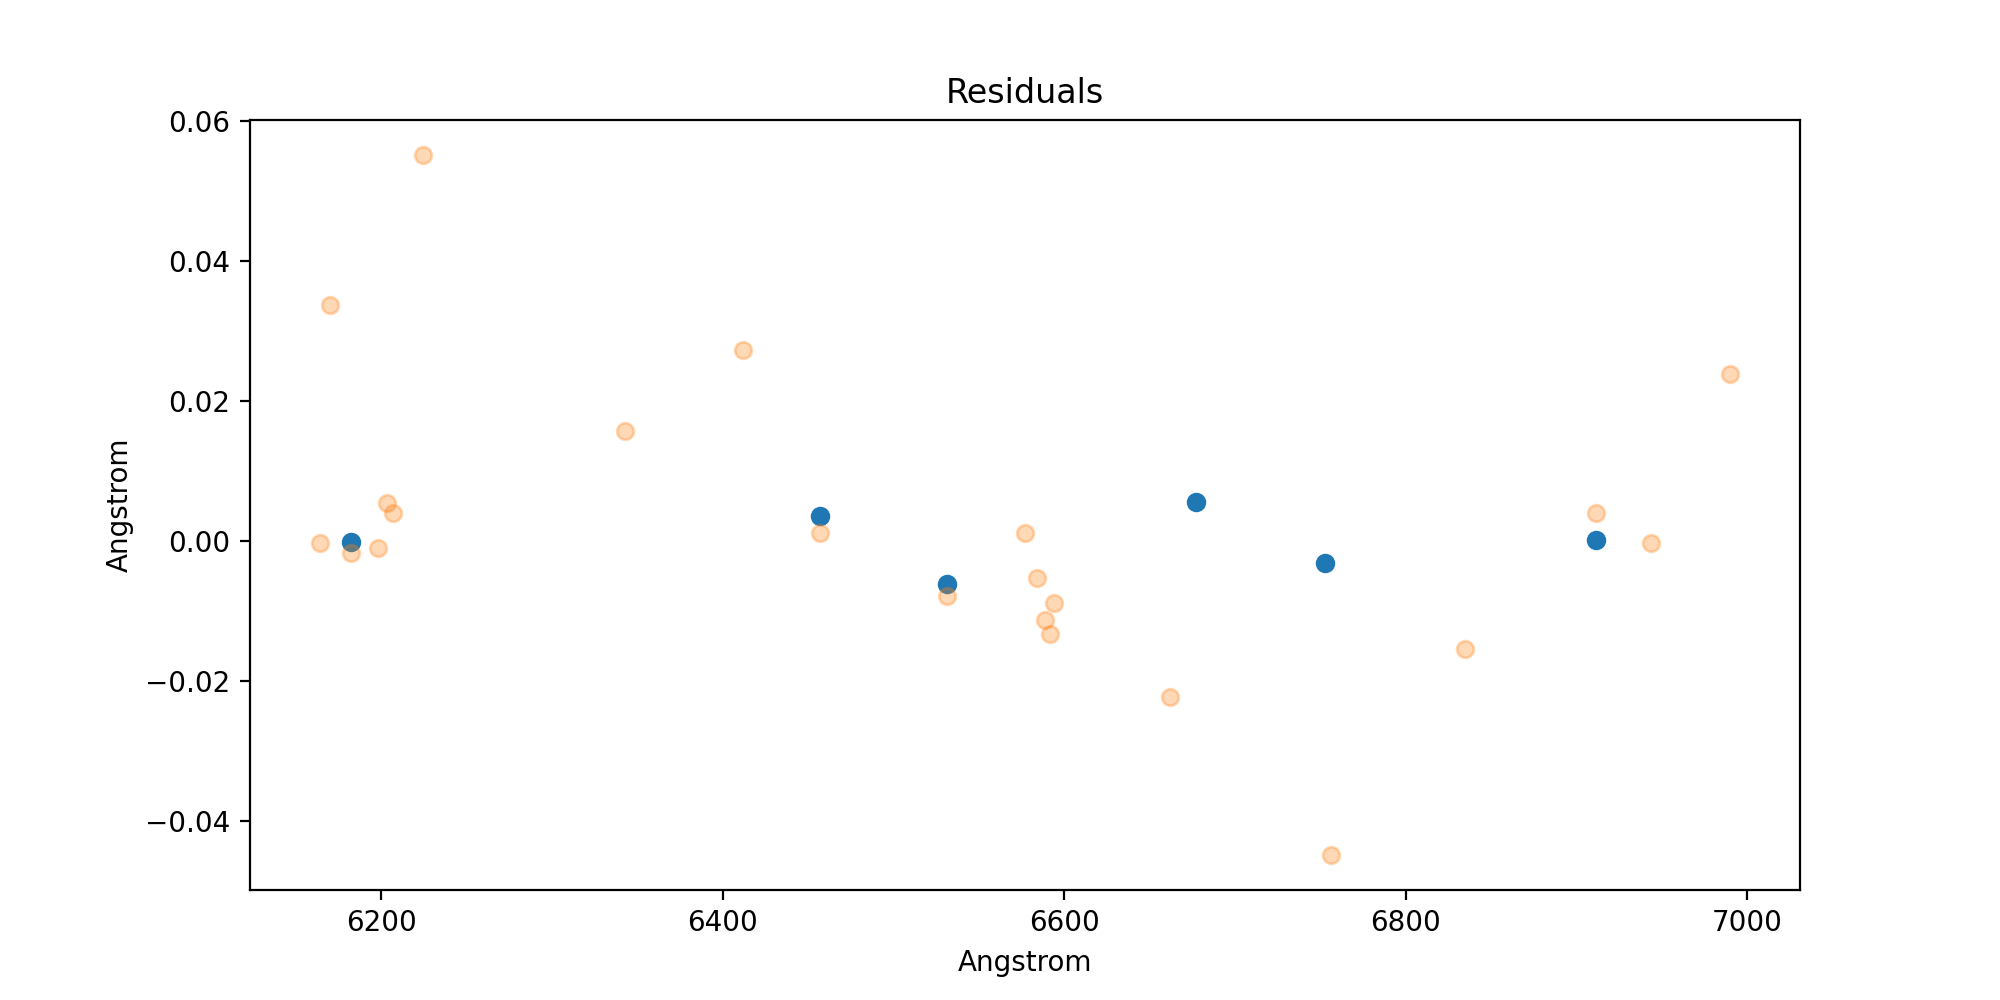

[ 6.07608391e+03  4.47728943e-01 -4.99319201e-09 -1.25459823e-11]


<IPython.core.display.Javascript object>


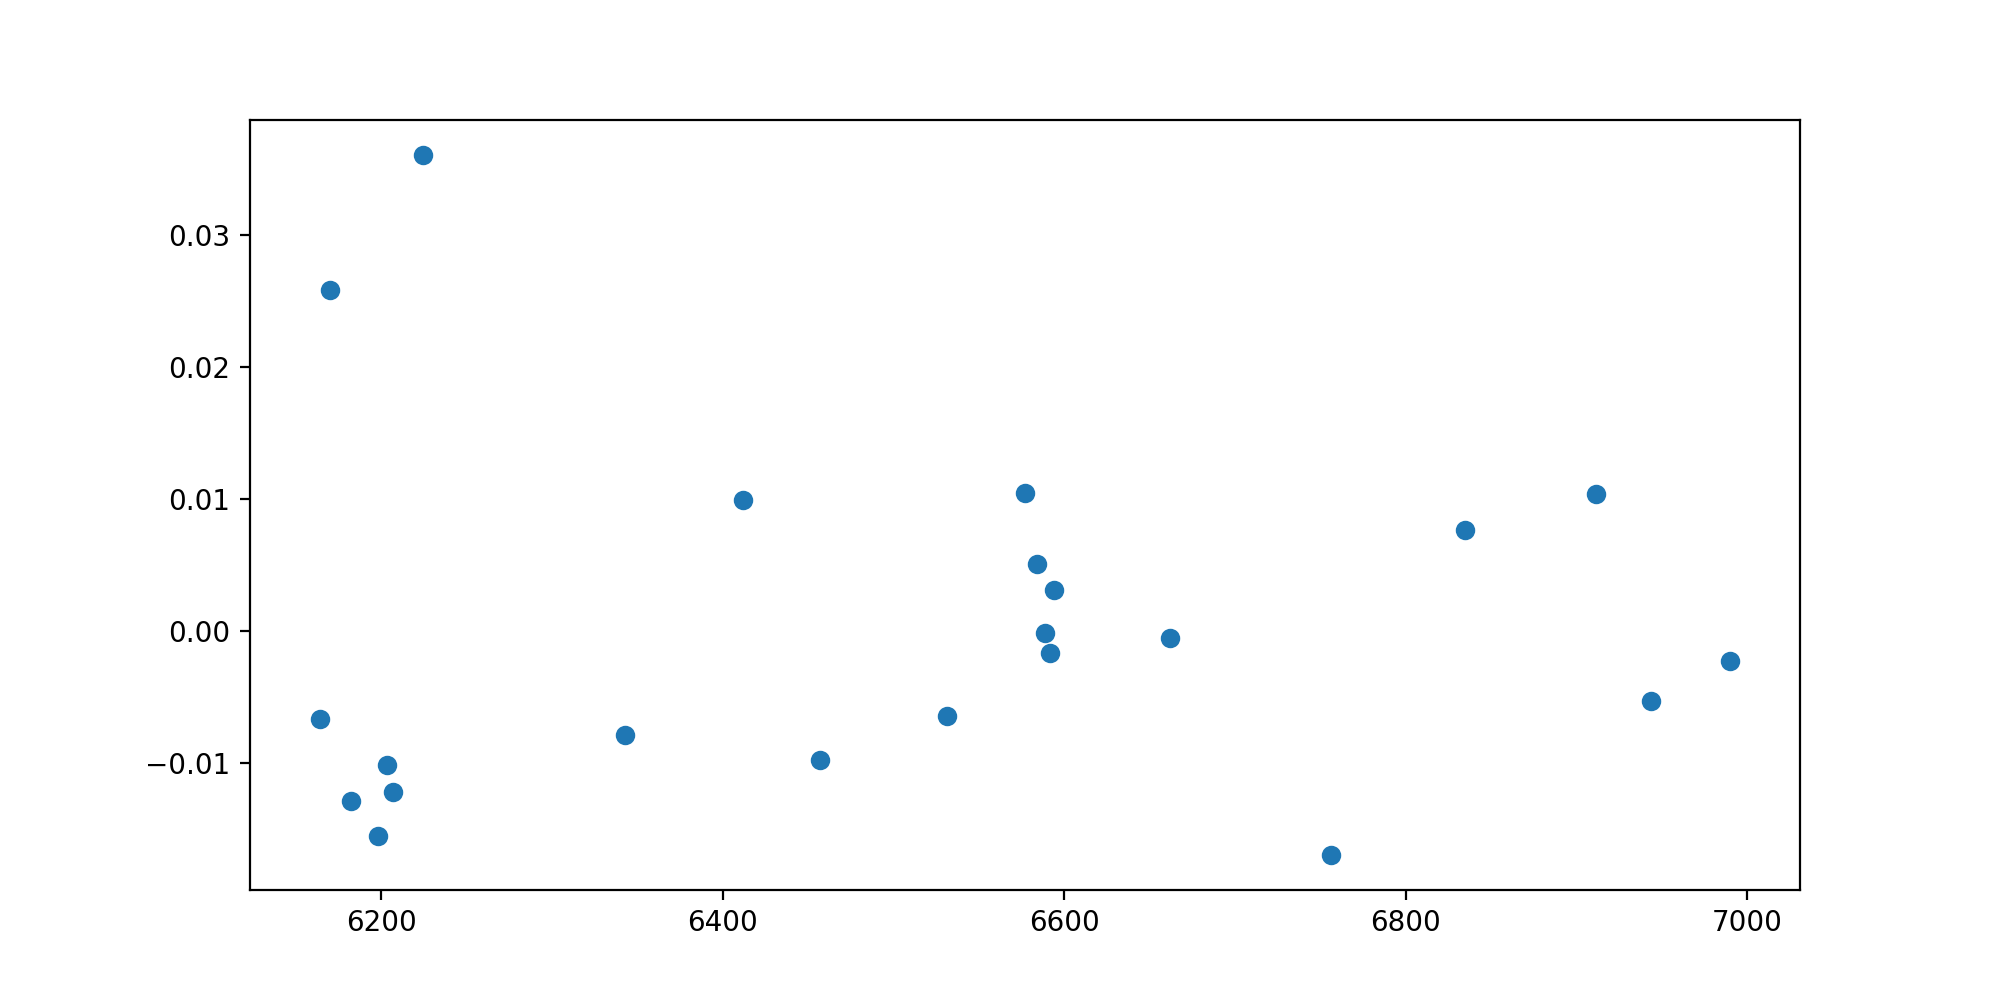

RESIDUALS AVG 5.374286874112758e-13
RESIDUALS RMS 0.012785115307359981
RESIDUALS RMS 0.5895586998437278 km/s


In [541]:
# make your list of at least 5 lines identified from the atlas
nguess=6
guess=np.zeros((nguess,2)) # column 1 => pixels, column2 => wavelength from atlas
guess[0]=[allcens[5],6182.62]
guess[1]=[allcens[13],6457.28]
guess[2]=[allcens[14],6531.34]
guess[3]=[allcens[21],6677.28]
guess[4]=[allcens[22],6752.83]
guess[5]=[allcens[26],6911.23]

plt.figure(figsize=(5,5))
plt.scatter(guess[:,0],guess[:,1])

from numpy.polynomial import chebyshev
# Fit a Chebyshev polynomial of degree 3
degree = 3
coeffs = chebyshev.chebfit(guess[:,0], guess[:,1], degree)
# Evaluate the Chebyshev polynomial at the x_range
y_fit = chebyshev.chebval(xaxis, coeffs)
plt.plot(xaxis, y_fit, label=f'Chebyshev Polynomial (Degree {degree})', color='red')

# and now add the other lines from NIST
file_path = 'ThI.csv'
# Load the data from the CSV file
dataThI = np.loadtxt(file_path, delimiter=',', skiprows=1)  # Skip the header row
print(file_path,len(dataThI))
data=dataThI
# Split the data into 'wls' and 'rels' arrays
NIST_wls = data[:, 0]  # Assumes wavelength is in the first column
NIST_rels = data[:, 1]  # Assumes intensity is in the second column
NIST_rels=NIST_rels/np.max(NIST_rels)
# make sure we have the same number of lines in NIST as in OBS
sNIST_rels=np.sort(NIST_rels)[::-1]
nlinesNIST=30
relmin=sNIST_rels[nlinesNIST]
# or maybe relax taht constraint by some factor:
ind=np.where(NIST_rels>=relmin)[0]
NIST_wls=NIST_wls[ind]
NIST_rels=NIST_rels[ind]

match = np.zeros(num_peaks)
predicted=np.zeros(num_peaks)
realNIST=np.zeros(num_peaks)
residuals = np.zeros(num_peaks)

maxdelta=1. # Angstrom

for i in range(num_peaks):
    predicted[i]=chebyshev.chebval(allcens[i],coeffs)
    imin=np.argmin(np.abs(predicted[i]-NIST_wls))
    residuals[i]=(predicted[i]-NIST_wls[imin])
    realNIST[i]=NIST_wls[imin]
    if(np.abs(residuals[i])<maxdelta):
        match[i]=imin

ind=np.where(match!=0)[0]
plt.scatter(allcens[ind],predicted[ind],alpha=0.3)
   

#    for j in range(nlinesNIST):
#        if ()
#    print(imin)

#print(match)

print(coeffs)
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(guess[:,1],-(guess[:,1]-chebyshev.chebval(guess[:,0], coeffs)),label='first guess')
ind=np.where(match!=0)[0]
plt.scatter(chebyshev.chebval(allcens[ind],coeffs),residuals[ind],alpha=0.3,label='posterior, NIST')

plt.title('Residuals')
plt.xlabel('Angstrom')
plt.ylabel('Angstrom')
plt.show()


# now try that again now that we have these additional lines
newguess=np.zeros((len(ind),2))
newguess[:,0]=allcens[ind]
newguess[:,1]=realNIST[ind]
#guess=np.concatenate((guess,newguess),axis=0)
guess=newguess

coeffs = chebyshev.chebfit(guess[:,0], guess[:,1], degree)
print(coeffs)
# Evaluate the Chebyshev polynomial at the x_range
y_fit = chebyshev.chebval(xaxis, coeffs)
plt.figure(figsize=(10,5))
plt.scatter(guess[:,1],-(guess[:,1]-chebyshev.chebval(guess[:,0], coeffs)),label='second iteration')
plt.show()
print('RESIDUALS AVG',np.average(guess[:,1]-chebyshev.chebval(guess[:,0], coeffs)))

print('RESIDUALS RMS',np.std(guess[:,1]-chebyshev.chebval(guess[:,0], coeffs)))
print('RESIDUALS RMS',(np.std(guess[:,1]-chebyshev.chebval(guess[:,0], coeffs))/np.average(guess[:,1]))*3.e5,'km/s')
wavelengths=chebyshev.chebval(xaxis, coeffs)



<IPython.core.display.Javascript object>


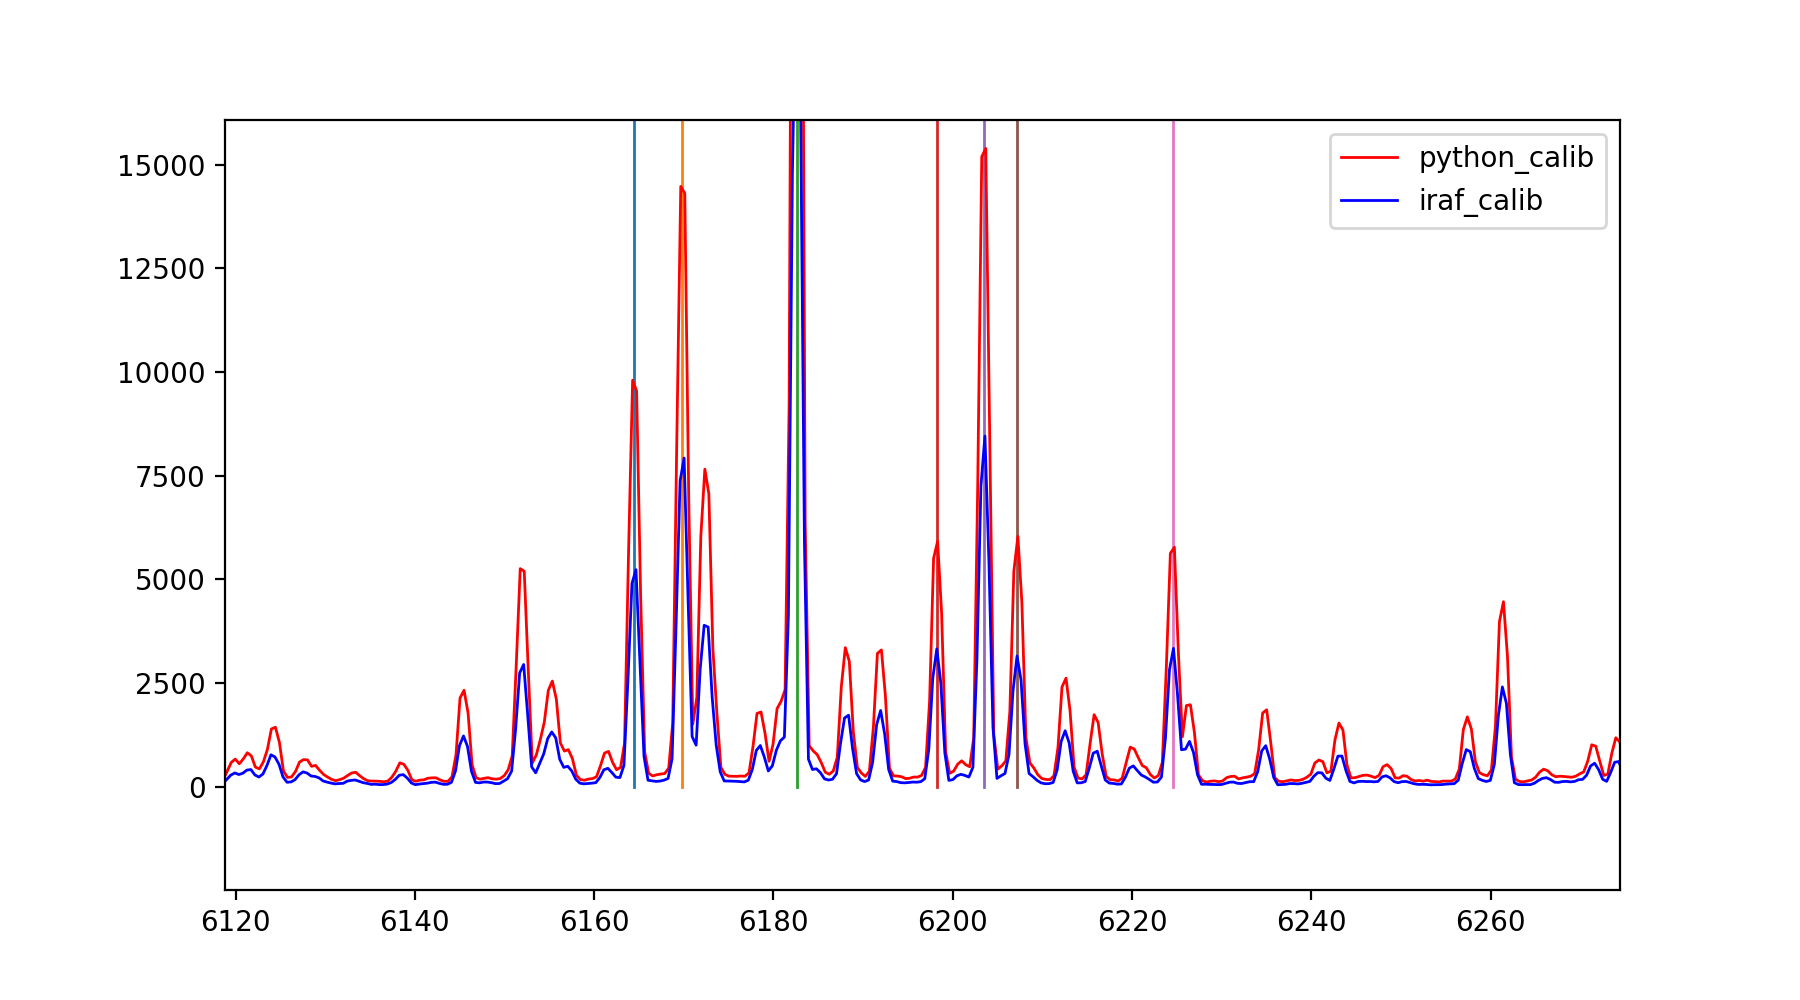

6164.4794
6169.82197
6182.62159
6198.22259
6203.49239
6207.22
6224.5271
6342.85945
6411.89903
6457.28237
6531.3417
6577.21443
6583.90576
6588.53948
6591.4843
6593.93902
6662.2685
6756.45269
6834.92448
6911.2262
6943.61047
6989.6552


In [557]:
# AND NOW FOR MY NEXT TRICK, replot the lamp spectrum using the new calibration
# Plot the spectrum and mark the centroids
fits_file = '../data/t152_spectro/lamp_thar/p67507.fits'
xaxis1,data1=read_raw_spectrum(fits_file)
wavelengths=chebyshev.chebval(xaxis1, coeffs)


iraf_file='../lamp_thar/thar_lambda.fits'
#xaxis,data=read_raw_spectrum(iraf_file)
wave,data_iraf=read_calibrated_spectrum(iraf_file)

plt.figure(figsize=(9, 5))

# ok so which lines did we actually end up using?
nguess=(len(guess))
for i in range(nguess):
    print(guess[i,1])
    plt.plot(np.full(100,guess[i,1]),np.linspace(0.,60000.,100),lw=1)


plt.plot(wavelengths,data1,label='python_calib',lw=1,color='r')
plt.plot(wave,data_iraf,label='iraf_calib',lw=1,color='b')
plt.legend()

plt.show()

In [551]:
print(np.linspace(0.,60000.,100))

[    0.           606.06060606  1212.12121212  1818.18181818
  2424.24242424  3030.3030303   3636.36363636  4242.42424242
  4848.48484848  5454.54545455  6060.60606061  6666.66666667
  7272.72727273  7878.78787879  8484.84848485  9090.90909091
  9696.96969697 10303.03030303 10909.09090909 11515.15151515
 12121.21212121 12727.27272727 13333.33333333 13939.39393939
 14545.45454545 15151.51515152 15757.57575758 16363.63636364
 16969.6969697  17575.75757576 18181.81818182 18787.87878788
 19393.93939394 20000.         20606.06060606 21212.12121212
 21818.18181818 22424.24242424 23030.3030303  23636.36363636
 24242.42424242 24848.48484848 25454.54545455 26060.60606061
 26666.66666667 27272.72727273 27878.78787879 28484.84848485
 29090.90909091 29696.96969697 30303.03030303 30909.09090909
 31515.15151515 32121.21212121 32727.27272727 33333.33333333
 33939.39393939 34545.45454545 35151.51515152 35757.57575758
 36363.63636364 36969.6969697  37575.75757576 38181.81818182
 38787.87878788 39393.93

<IPython.core.display.Javascript object>


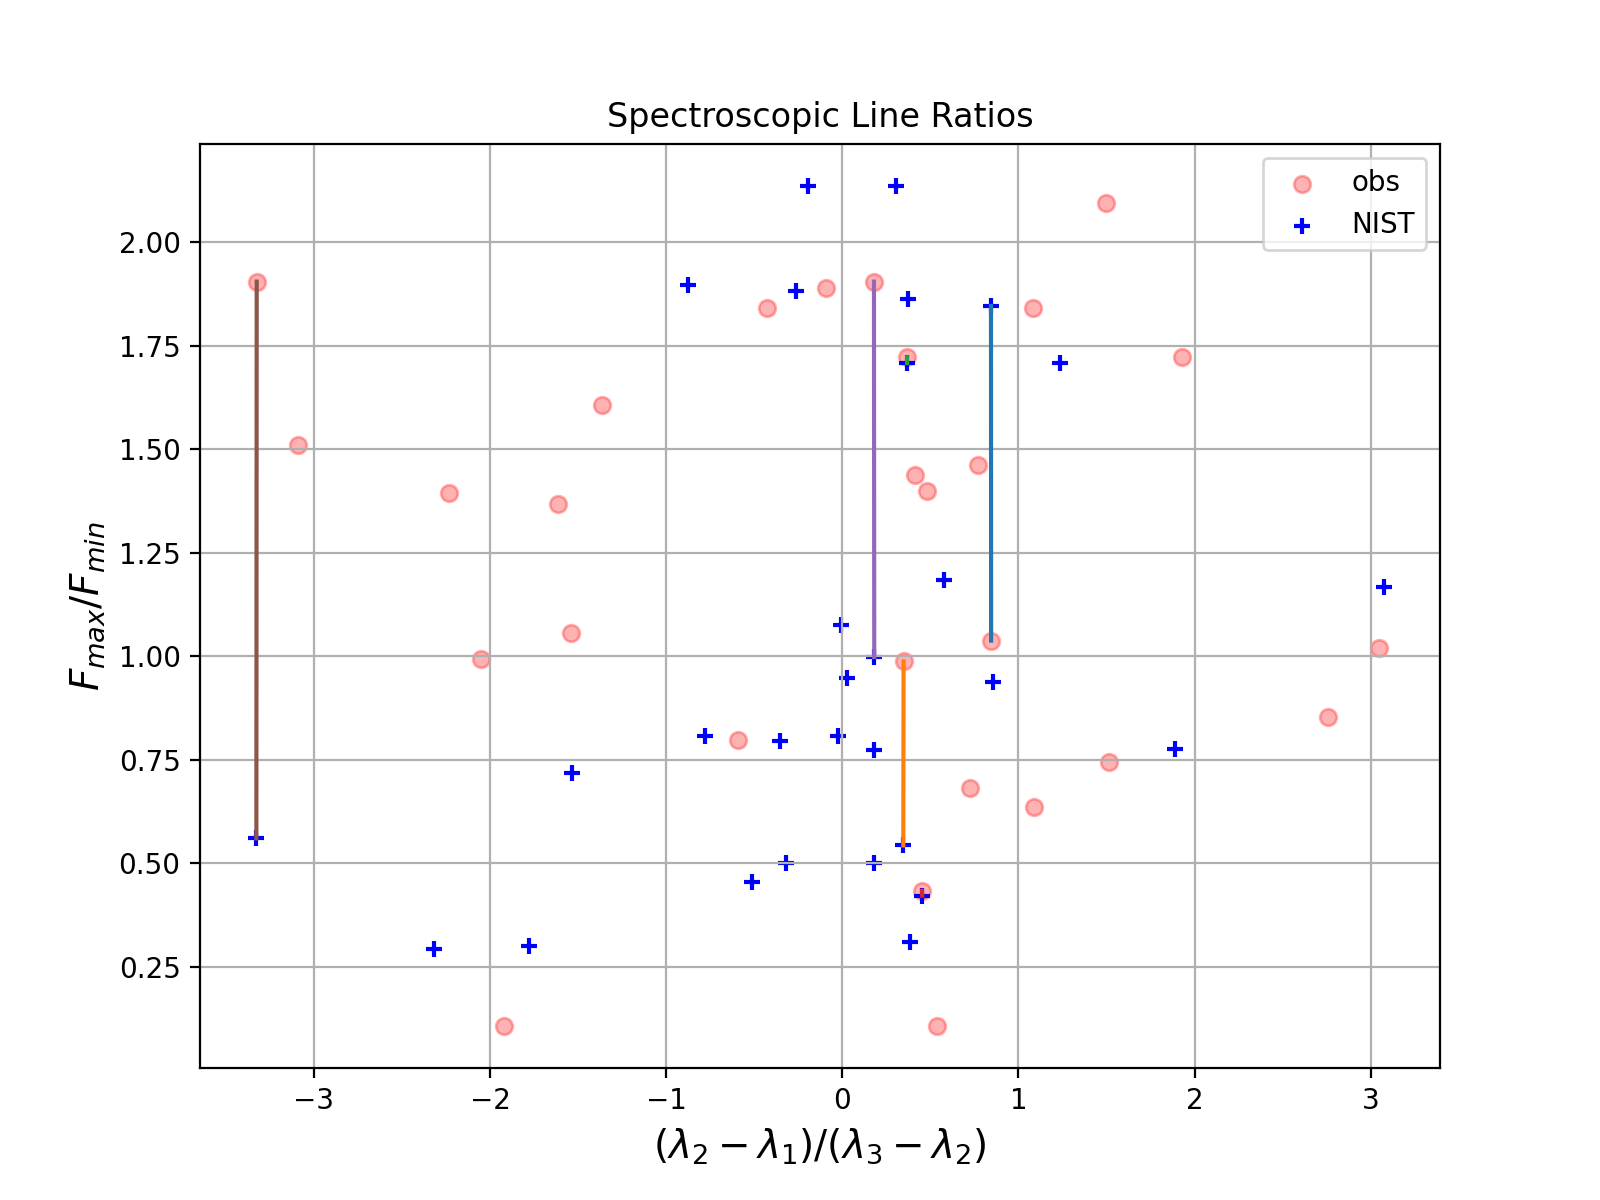

Number of lines  obs 30
ThI.csv 1376
ArI.csv 32
ArII.csv 123
ThII.csv 351
1882
Number of lines  NIST 32
0.8446778920467242 0.8440457658134465 1.0373021274287633 1.845826690498331
0.347802556945641 0.3462251335519781 0.9870789535851316 0.542574322080571
0.3677732935702431 0.36745265734242866 1.7217205028347586 1.707877985247353
0.4526908470344537 0.45331230653185367 0.43303300803117994 0.4212134650763035
0.1795882498815631 0.18131057113940677 1.904586863669235 0.9976363713281075
-3.3244126909330403 -3.3263285968477287 1.904586863669235 0.5596157879354228


<ipython-input-446-d79e7987255a>:116: RuntimeWarning: invalid value encountered in log
  x2=np.log(ratios_1_2_3)
<ipython-input-446-d79e7987255a>:119: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.log(ratios_1_2_3), np.log(minmaxampratio), c=col,marker=m, label=leg,alpha=al)


In [446]:
# BELOW IS INTERESTING BUT NOT ESSENTIAL CODE
# TO KEEP OUT OF CURIOSITY
# A VERY DARING THOUGH NOT VERY SUCCESSFUL ATTEMPT TO AUTOMATICALLY MATCH AT LEAST A FEW LINES BASED SOLELY ON NIST INFORMATION!
# it works for a few lines but not across the whole spectrum
vals=['obs','NIST']
# select matching triplets
deltalwl=0.002
deltalF=13.5
relax_factor=0.9
nvals=len(vals)
x1=[]
y1=[]
x2=[]
y2=[]
# Create a 2D scatter plot
plt.figure(figsize=(8, 6))

for i in range(nvals):

    
    if(i==0):
        # Plot the lamp spectrum ratios
        obs_wls=allcens
        obs_amps=allamps/np.max(obs_amps)
        spectroscopic_lines = obs_wls
        amps=obs_amps
        col='r'
        leg='obs'
        al=0.3
        m='o'
        nlines_obs=len(obs_wls)
        
    if(i==1):
        al=1.
        col='b'
        leg='NIST'
        m='+'
        dataThI=[]
        dataArI=[]
        dataArII=[]
        dataThII=[]
        data=[]
        # Plot the NIST file ratios
        # Define the file path
        if(1):
            file_path = 'ThI.csv'
            # Load the data from the CSV file
            dataThI = np.loadtxt(file_path, delimiter=',', skiprows=1)  # Skip the header row
            print(file_path,len(dataThI))
        
        if(1):
            file_path = 'ArI.csv'
            # Load the data from the CSV file
            dataArI = np.loadtxt(file_path, delimiter=',', skiprows=1)  # Skip the header row
            print(file_path,len(dataArI))

        file_path = 'ArII.csv'
        # Load the data from the CSV file
        dataArII = np.loadtxt(file_path, delimiter=',', skiprows=1)  # Skip the header row
        print(file_path,len(dataArII))
        file_path = 'ThII.csv'
        # Load the data from the CSV file
        dataThII = np.loadtxt(file_path, delimiter=',', skiprows=1)  # Skip the header row
        print(file_path,len(dataThII))
        
        
#        data=np.concatenate((dataThI,dataArI,dataArII,dataThII),axis=0)
        data=np.concatenate((dataThII,dataArII,dataArI,dataThI),axis=0)
        print(len(data))
        
        # Split the data into 'wls' and 'rels' arrays
        NIST_wls = data[:, 0]  # Assumes wavelength is in the first column
        NIST_rels = data[:, 1]  # Assumes intensity is in the second column
        NIST_rels=NIST_rels/np.max(NIST_rels)
        # make sure we have the same number of lines in NIST as in OBS
        sNIST_rels=np.sort(NIST_rels)[::-1]
        relmin=sNIST_rels[nlines_obs-1]
        # or maybe relax taht constraint by some factor:
        ind=np.where(NIST_rels>=relmin*relax_factor)[0]
        NIST_wls=NIST_wls[ind]
        NIST_rels=NIST_rels[ind]

        spectroscopic_lines = NIST_wls
        amps=NIST_rels


    print('Number of lines ',vals[i],len(spectroscopic_lines))


    # Calculate the ratios lambda1/lambda2 and lambda2/lambda3
    
    deltas_1_2 = [l2 - l1 for l1, l2 in zip(spectroscopic_lines[:-1], spectroscopic_lines[1:])]
    deltas_2_3 = [l3 - l2 for l2, l3 in zip(spectroscopic_lines[1:], spectroscopic_lines[2:])]
    deltas_1_3 = [l3 - l1 for l1, l3 in zip(spectroscopic_lines[:-1], spectroscopic_lines[2:])]
    avgamps= [ np.average([a1,a2,a3]) for a1, a2, a3 in zip(amps[:-1], amps[1:],amps[2:])]
    maxamps= [ np.max([a1,a2,a3]) for a1, a2, a3 in zip(amps[:-1], amps[1:],amps[2:])]
    minamps= [ np.min([a1,a2,a3]) for a1, a2, a3 in zip(amps[:-1], amps[1:],amps[2:])]



#    print(len(deltas_1_2))
#    print(len(deltas_1_3))
#    print(len(avgamps))

    # Ensure both lists have the same size
    min_size = min(len(deltas_1_2), len(deltas_2_3),len(deltas_1_3),len(avgamps))
    deltas_1_2 = deltas_1_2[:min_size]
    deltas_2_3 = deltas_2_3[:min_size]
    deltas_1_3 = deltas_1_3[:min_size]
    ratios_1_2=np.array(deltas_1_2)/np.array(deltas_1_3)
    ratios_2_3=np.array(deltas_2_3)/np.array(deltas_1_3)
    ratios_1_2_3=np.array(deltas_1_2)/np.array(deltas_2_3)
    minmaxampratio=np.array(maxamps)/np.array(minamps)

    if(i==0):
        x1=np.log(ratios_1_2_3)
        y1=np.log(minmaxampratio)
        
    if(i==1):
        x2=np.log(ratios_1_2_3)
        y2=np.log(minmaxampratio)
    
    plt.scatter(np.log(ratios_1_2_3), np.log(minmaxampratio), c=col,marker=m, label=leg,alpha=al)
    
#plt.colorbar()

# Label the axes
plt.xlabel('$(\lambda_2-\lambda_1)/(\lambda_3-\lambda_2)$', fontsize=14)
plt.ylabel('$F_{max}/F_{min}$', fontsize=14)
#plt.xscale('log')
#plt.yscale('log')

# Add a grid
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.title('Spectroscopic Line Ratios')
#plt.show()

deltax=deltalwl
deltay=deltalF

# Initialize a list to store pairs of points that satisfy the conditions
satisfying_pairs = []
matches=[] # 0 is obs, 1 is NIST

# Loop through each pair of points from (x1, y1) and (x2, y2)
for i in range(len(x1)):
    for j in range(len(x2)):
        if np.abs(x1[i] - x2[j]) < deltax and np.abs(y1[i] - y2[j]) < deltay:
            satisfying_pairs.append((x1[i], y1[i], x2[j], y2[j]))
            matches.append((i,j))


            
# build the final line list obs vs NIST
            
for pair in satisfying_pairs:
    x1, y1, x2, y2 = pair
#    plt.scatter(x1,y1,alpha=0.)
#    plt.scatter(x2,y2)
    plt.plot([x1,x2],[y1,y2])
    print(x1,x2,y1,y2)
#    print(x1)
            
plt.show()

[(1, 5), (6, 9), (15, 21), (16, 22), (17, 8), (18, 24)]


<IPython.core.display.Javascript object>


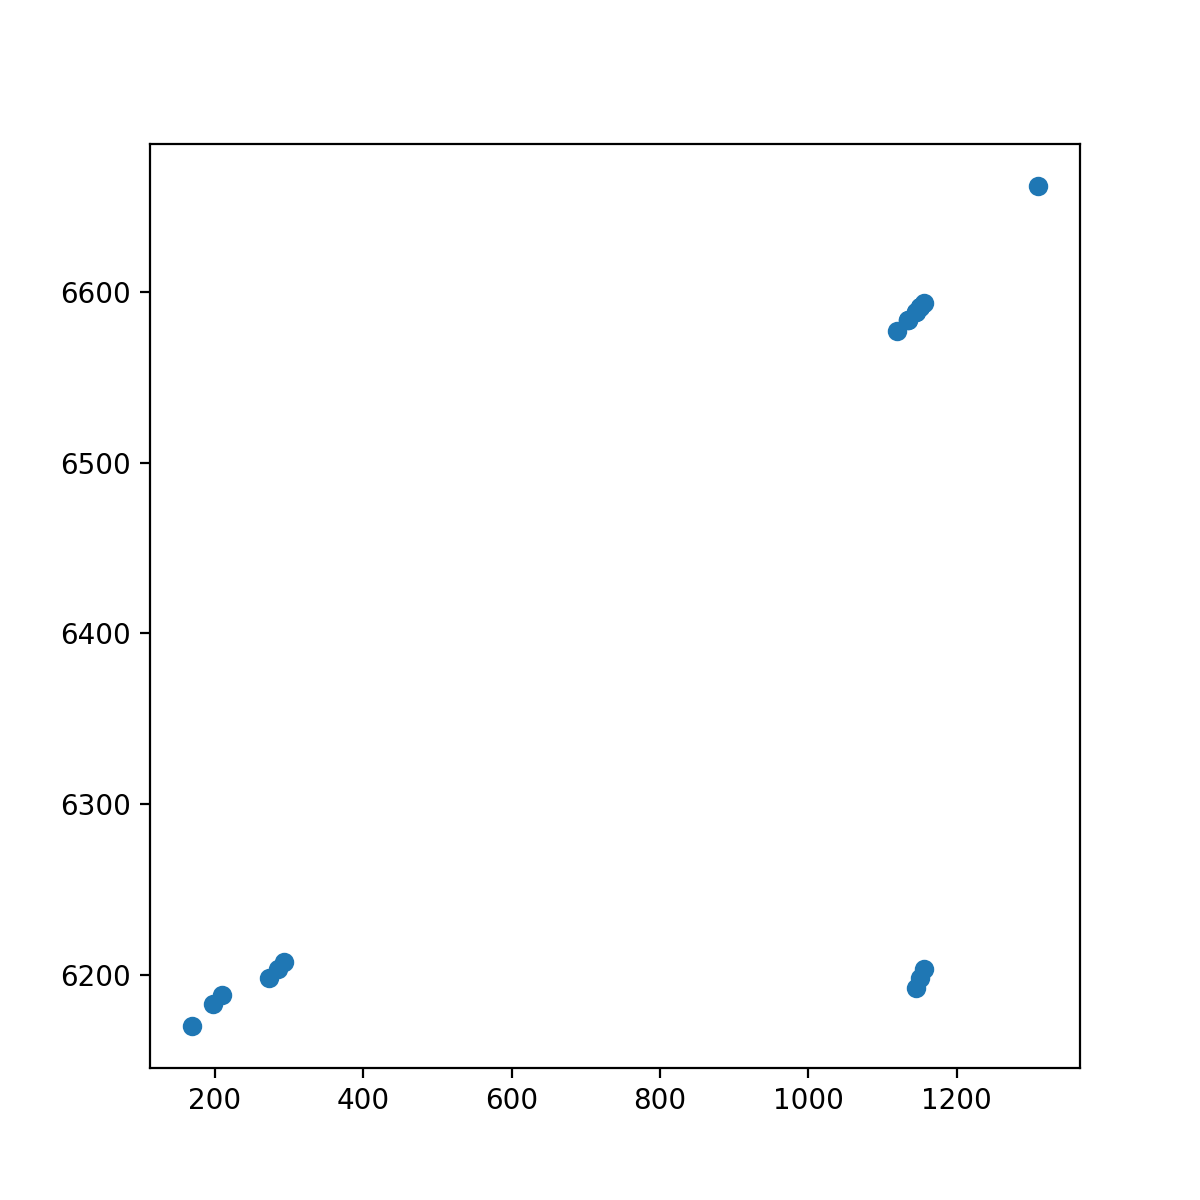

In [447]:
# plot obs pixels vs obs line
print(matches)
nm=len(matches)
lobs1=np.zeros(nm)
lobs2=np.zeros(nm)
lobs3=np.zeros(nm)

lnist1=np.zeros(nm)
lnist2=np.zeros(nm)
lnist3=np.zeros(nm)

for i in range(nm):
    j,k=matches[i]
#    print(j,k)
    lobs1[i]=obs_wls[:-1][j]
    lobs2[i]=obs_wls[1:][j]
    lobs3[i]=obs_wls[2:][j]
#    print(np.log((lobs2[i]-lobs1[i])/(lobs3[i]-lobs2[i])))
    lnist1[i]=NIST_wls[:-1][k]
    lnist2[i]=NIST_wls[1:][k]
    lnist3[i]=NIST_wls[2:][k]
#    print(np.log((lnist2[i]-lnist1[i])/(lnist3[i]-lnist2[i])))

lobs=[]
lnist=[]
lobs=np.append(lobs,[lobs1,lobs2,lobs3])
lnist=np.append(lnist,[lnist1,lnist2,lnist3])    

plt.figure(figsize=(6,6))
plt.scatter(lobs,lnist)
plt.show()